In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alexaamazonds/EcoPreprocessed.csv


In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/alexaamazonds/EcoPreprocessed.csv")
print(df.head(10))

   Unnamed: 0                                             review  polarity  \
0        3870                            able play youtube alexa    0.5000   
1          62  able recognize indian accent really well drop ...    0.2794   
2         487  absolute smart device amazon connect external ...    0.1827   
3        3204  absolutely amaze new member family control hom...    0.3682   
4        1265  absolutely amaze previously sceptical invest m...    0.2333   
5          53  absolutely cheat customer if buy amazon produc...    0.1350   
6         257  absolutely house hold item fair price intuitiv...    0.4250   
7        1258  absolutely mind blow device beautiful shape ex...    0.5262   
8        3499                              accept dutch language    0.0000   
9        2578  accessibility limit amazon apps music appsexce...   -0.0905   

   division  
0  positive  
1  positive  
2  positive  
3  positive  
4  positive  
5  positive  
6  positive  
7  positive  
8   neutral  
9

In [3]:

print(df.shape)

print(df.columns)

print(df.isnull().sum())

# Display random sample
df.sample(5)

(4084, 4)
Index(['Unnamed: 0', 'review', 'polarity', 'division'], dtype='object')
Unnamed: 0    0
review        0
polarity      0
division      0
dtype: int64


,Unnamed: 0,review,polarity,division
3441,1327,sound quality bass good good experience hindi ...,0.4650,positive
1561,3032,good product,0.7000,positive
2835,2395,nothing dislikedand like much purchase another...,0.4000,positive
2943,1125,pathetic experience make several complaints bu...,-0.3712,negative
2248,1791,make purchase next day price reduce sffered lo...,-0.3500,negative


Se have 2 Datasets. One on 4000 row. Another one on 30 000+ rows. So we will test on a first one?

In [4]:
splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
df_hf_multi_train = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])

print(df_hf_multi_train.shape)

print(df_hf_multi_train.columns)

print(df_hf_multi_train.isnull().sum())

# Display random sample
df_hf_multi_train.sample(5)

(31232, 4)
Index(['id', 'text', 'label', 'sentiment'], dtype='object')
id           0
text         0
label        0
sentiment    0
dtype: int64


,id,text,label,sentiment
26468,457,I am living in a country where the government ...,0,negative
2477,26706,": Hi, there! I`m sorry for not telling you L...",1,neutral
9855,11482,Got 5 new followers yesterday! Yay Just need ...,2,positive
9861,25393,girl you stay inviting me but not doing a fol...,0,negative
25618,8881,hahaha i have a bob marley one,1,neutral


In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

2025-08-08 20:04:08.996581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754683449.253959      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754683449.337250      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
df['division'].value_counts()

division
positive    3066
neutral      536
negative     482
Name: count, dtype: int64

In [7]:
df_hf_multi_train['sentiment'].value_counts()

sentiment
neutral     11649
positive    10478
negative     9105
Name: count, dtype: int64

The Second Dataset would be much better. It`s more evenly distributed.

In [8]:
df_hf_multi_val = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["validation"])
df_hf_multi_test = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["test"])
print(df_hf_multi_val.shape)
print(df_hf_multi_test.shape)

(5205, 4)
(5206, 4)


We will drop redundant columns: id and sentiment. (Sentiment because labe is already sentiment ==> 2 = positive; 0 = negative; 1 = neutral)

In [9]:
#display(df_hf_multi_train.drop('id', axis = 1))
#label_map = {'positive': 2, 'neutral': 1, ,'negative': 0}
#df_hf_multi_train['label'] = df_hf_multi_train['sentiment'].map(label_map)

df_hf_multi_train = df_hf_multi_train.drop(columns=['id'])
df_hf_multi_train = df_hf_multi_train.drop(columns=['sentiment'])
display(df_hf_multi_train.head())


,text,label
0,"Cooking microwave pizzas, yummy",2
1,Any plans of allowing sub tasks to show up in ...,1
2,"I love the humor, I just reworded it. Like sa...",2
3,naw idk what ur talkin about,1
4,That sucks to hear. I hate days like that,0


Distribution for Test and Validation sets

In [10]:
print(df_hf_multi_test.shape)

print(df_hf_multi_test.columns)

print(df_hf_multi_test.isnull().sum())

# Display random sample
df_hf_multi_test.sample(5)

(5206, 4)
Index(['id', 'text', 'label', 'sentiment'], dtype='object')
id           0
text         1
label        0
sentiment    0
dtype: int64


,id,text,label,sentiment
3849,6046,"I like tweetie better, that is what I use all...",2,positive
113,24634,cleaning and packing,1,neutral
2953,20283,and i got hello kitty tattoos! she`s a balle...,1,neutral
634,26996,Fresh change from hearing i write sins hey!!?...,1,neutral
5016,12140,I hate today.,0,negative


In [11]:
print(df_hf_multi_val.shape)

print(df_hf_multi_val.columns)

print(df_hf_multi_val.isnull().sum())

# Display random sample
df_hf_multi_val.sample(5)

(5205, 4)
Index(['id', 'text', 'label', 'sentiment'], dtype='object')
id           0
text         0
label        0
sentiment    0
dtype: int64


,id,text,label,sentiment
1307,25836,Lunch isn`t until 1:00 but I`m already so hungry.,0,negative
1239,25948,i totally felt bad for the guy. haha im good ...,1,neutral
2619,6605,looks same in Noida too,1,neutral
1589,15392,"Sweeny Todd is an awesome movie, the best",2,positive
4522,10741,ment to be doing hw but not going to happen!!...,1,neutral


In [12]:
# Show all rows with at least one NaN value
df_hf_multi_test[df_hf_multi_test.isnull().any(axis=1)]

,id,text,label,sentiment
3751,314,NaN,1,neutral


In [13]:
#check specific row
df_hf_multi_test.loc[3751]

id               314
text             NaN
label              1
sentiment    neutral
Name: 3751, dtype: object

In [14]:
df_hf_multi_test[df_hf_multi_test['text'].isnull()]

,id,text,label,sentiment
3751,314,NaN,1,neutral


In [15]:
#df_hf_multi_test = df_hf_multi_test[df_hf_multi_test['text'].notnull()]

df_hf_multi_test = df_hf_multi_test.dropna()

#df_hf_multi_test = df_hf_multi_test.drop(index=3751, errors='ignore')
#If your DataFrame has a default integer index and you want to reset it after deletion:
#df_hf_multi_test = df_hf_multi_test.reset_index(drop=True)

In [16]:
print(df_hf_multi_test.isnull().sum())

id           0
text         0
label        0
sentiment    0
dtype: int64


We want to delete redundant columns for Test and Validation dataset?

In [17]:
df_hf_multi_test = df_hf_multi_test.drop(columns=['id'])
df_hf_multi_test = df_hf_multi_test.drop(columns=['sentiment'])
display(df_hf_multi_test.head())
df_hf_multi_val = df_hf_multi_val.drop(columns=['id'])
df_hf_multi_val = df_hf_multi_val.drop(columns=['sentiment'])
display(df_hf_multi_val.head())

,text,label
0,getting cds ready for tour,1
1,"MC, happy mother`s day to your mom ;).. love yah",2
2,A year from now is graduation....i am pretty s...,0
3,because you had chips and sale w/o me,1
4,Great for organising my work life balance,2


,text,label
0,Laying in bed til workkk... Oh the life. Defin...,0
1,ooohhh imma need you to get on that asap love...,2
2,"Thanks! I love it they have a video, so you d...",2
3,I left my ipod in the car so now its all warm.,2
4,Great app. Only complaint is that I'd like the...,2


In [18]:

df_t_len = pd.DataFrame()
# Assuming df is your DataFrame and 'text' is the column
df_t_len['text_length'] = df_hf_multi_train['text'].apply(lambda x: len(str(x)))

df_t_len['text_length']

0         31
1         57
2        128
3         29
4         42
        ... 
31227     48
31228     21
31229      9
31230     95
31231     15
Name: text_length, Length: 31232, dtype: int64

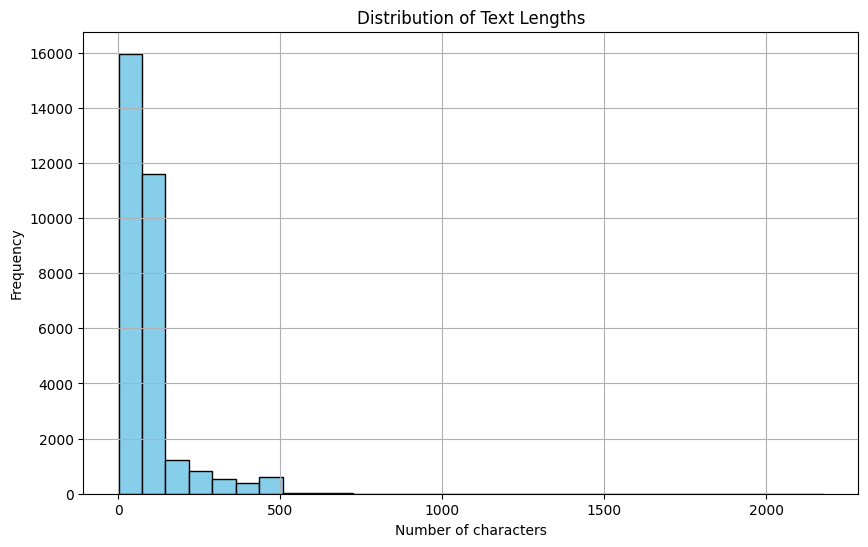

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_t_len['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [20]:
!pip install transformers datasets torch scikit-learn

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [21]:
#Dynamic padding for memory and speed efficiency

def tokenize_text(text):
    return tokenizer(text, padding=True, truncation=True)

df_hf_multi_train['tokenized'] = df_hf_multi_train['text'].apply(tokenize_text)


df_hf_multi_train['tokenized']


0        [input_ids, token_type_ids, attention_mask]
1        [input_ids, token_type_ids, attention_mask]
2        [input_ids, token_type_ids, attention_mask]
3        [input_ids, token_type_ids, attention_mask]
4        [input_ids, token_type_ids, attention_mask]
                            ...                     
31227    [input_ids, token_type_ids, attention_mask]
31228    [input_ids, token_type_ids, attention_mask]
31229    [input_ids, token_type_ids, attention_mask]
31230    [input_ids, token_type_ids, attention_mask]
31231    [input_ids, token_type_ids, attention_mask]
Name: tokenized, Length: 31232, dtype: object

In [22]:
df_hf_multi_train['tokenized'].iloc[0]

{'input_ids': [101, 8434, 18302, 10733, 2015, 1010, 9805, 18879, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
df_hf_multi_train['text'].iloc[0]

'Cooking microwave pizzas, yummy'

**We switched to Dynamic Padding**